In [1]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import dill

Starting time: 2018-12-23 06:19:00.684924+00:00


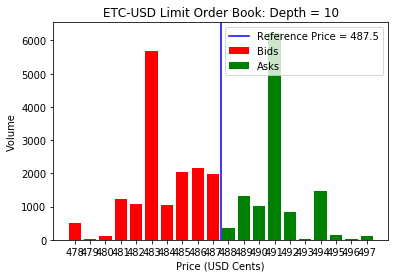

Reference Price: 487.5
---------------------------------------
First 10 Bids: 
478, 513.32169
479, 10.058
480, 115.258
481, 1219.93806141
482, 1079.44864163
483, 5690.64860072
484, 1044.26580999
485, 2036.82835309
486, 2162.94134543
487, 1992.38494076
---------------------------------------
First 10 Asks: 
488, 350.6803041
489, 1318.79202167
490, 1018.12588706
491, 6233.39414514
492, 835.2232479
493, 26.33785052
494, 1483.358
495, 139.86105619
496, 27.78542001
497, 114.49735792
---------------------------------------


Update: ('sell', '4.88000000', '237.7746041')
Time: 2018-12-23T06:19:06.653Z
---------------------------------------
Update: ('buy', '4.86000000', '2224.34134543')
Time: 2018-12-23T06:19:06.681Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:19:07.273Z
---------------------------------------
Update: ('sell', '4.92000000', '1335.2232479')
Time: 2018-12-23T06:19:07.360Z
---------------------------------------
Upd

Update: ('sell', '4.91000000', '6233.39414514')
Time: 2018-12-23T06:19:27.469Z
---------------------------------------
Update: ('buy', '4.85000000', '1536.82835309')
Time: 2018-12-23T06:19:27.597Z
---------------------------------------
Update: ('buy', '4.84000000', '1732.96580999')
Time: 2018-12-23T06:19:27.604Z
---------------------------------------
Update: ('buy', '4.84000000', '1790.06580999')
Time: 2018-12-23T06:19:28.698Z
---------------------------------------
Update: ('buy', '4.84000000', '1843.36580999')
Time: 2018-12-23T06:19:28.700Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:19:28.725Z
---------------------------------------
Update: ('sell', '4.92000000', '1335.2232479')
Time: 2018-12-23T06:19:28.829Z
---------------------------------------
Update: ('sell', '4.92000000', '835.2232479')
Time: 2018-12-23T06:19:29.046Z
---------------------------------------
Update: ('sell', '4.91000000', '6233.39414514')
Time: 2

Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:19:39.916Z
---------------------------------------
Update: ('sell', '4.92000000', '1345.4519003')
Time: 2018-12-23T06:19:40.006Z
---------------------------------------
Update: ('sell', '4.92000000', '845.4519003')
Time: 2018-12-23T06:19:40.141Z
---------------------------------------
Update: ('sell', '4.91000000', '6233.39414514')
Time: 2018-12-23T06:19:40.228Z
---------------------------------------
Update: ('sell', '4.89000000', '1374.55602167')
Time: 2018-12-23T06:19:41.179Z
---------------------------------------
Update: ('buy', '4.83000000', '5096.84314785')
Time: 2018-12-23T06:19:41.624Z
---------------------------------------
Update: ('buy', '4.82000000', '1580.26699228')
Time: 2018-12-23T06:19:41.641Z
---------------------------------------
Update: ('sell', '4.88000000', '349.4756041')
Time: 2018-12-23T06:19:41.835Z
---------------------------------------
Update: ('sell', '4.88000000', '236.5916041')
Time: 201

Update: ('sell', '4.88000000', '193.41201027')
Time: 2018-12-23T06:20:03.064Z
---------------------------------------
Update: ('buy', '4.50000000', '1616.10093304')
Time: 2018-12-23T06:20:03.795Z
---------------------------------------
Update: ('sell', '4.91000000', '5233.39414514')
Time: 2018-12-23T06:20:05.624Z
---------------------------------------
Update: ('sell', '4.92000000', '1345.4519003')
Time: 2018-12-23T06:20:05.642Z
---------------------------------------
Update: ('sell', '4.90000000', '1009.11401499')
Time: 2018-12-23T06:20:05.660Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:20:05.676Z
---------------------------------------
Update: ('sell', '4.90000000', '509.11401499')
Time: 2018-12-23T06:20:07.847Z
---------------------------------------
Update: ('sell', '4.91000000', '5233.39414514')
Time: 2018-12-23T06:20:07.858Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time

Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:20:23.877Z
---------------------------------------
Update: ('sell', '4.92000000', '1345.4519003')
Time: 2018-12-23T06:20:23.905Z
---------------------------------------
Update: ('buy', '4.85000000', '1421.4797')
Time: 2018-12-23T06:20:23.964Z
---------------------------------------
Update: ('sell', '4.91000000', '6233.39414514')
Time: 2018-12-23T06:20:24.001Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:20:24.155Z
---------------------------------------
Update: ('sell', '4.92000000', '1845.4519003')
Time: 2018-12-23T06:20:24.242Z
---------------------------------------
Update: ('buy', '4.83000000', '5096.84314785')
Time: 2018-12-23T06:20:24.676Z
---------------------------------------
Update: ('buy', '4.82000000', '1080.26699228')
Time: 2018-12-23T06:20:24.686Z
---------------------------------------
Update: ('buy', '4.84000000', '1347.56580999')
Time: 2018-1

Update: ('buy', '4.88000000', '748.20763162')
Time: 2018-12-23T06:20:41.489Z
---------------------------------------
Update: ('buy', '4.87000000', '1827.2960757')
Time: 2018-12-23T06:20:41.503Z
---------------------------------------
Update: ('buy', '4.87000000', '1797.2960757')
Time: 2018-12-23T06:20:41.503Z
---------------------------------------
Update: ('buy', '4.87000000', '1737.2960757')
Time: 2018-12-23T06:20:41.504Z
---------------------------------------
Update: ('buy', '4.84000000', '843.36580999')
Time: 2018-12-23T06:20:41.511Z
---------------------------------------
Update: ('buy', '4.84000000', '790.06580999')
Time: 2018-12-23T06:20:41.512Z
---------------------------------------
Update: ('buy', '4.84000000', '735.66580999')
Time: 2018-12-23T06:20:42.598Z
---------------------------------------
Update: ('buy', '4.86000000', '1600.04505917')
Time: 2018-12-23T06:20:42.605Z
---------------------------------------
Update: ('buy', '4.84000000', '678.56580999')
Time: 2018-12-23T

Update: ('sell', '4.89000000', '247.4138506')
Time: 2018-12-23T06:21:33.395Z
---------------------------------------
Update: ('sell', '4.90000000', '1658.99687329')
Time: 2018-12-23T06:21:34.009Z
---------------------------------------
Update: ('sell', '4.90000000', '1920.60687329')
Time: 2018-12-23T06:21:34.162Z
---------------------------------------
Update: ('buy', '4.84000000', '544.26580999')
Time: 2018-12-23T06:21:37.029Z
---------------------------------------
Update: ('buy', '4.83000000', '5013.00001')
Time: 2018-12-23T06:21:37.039Z
---------------------------------------
Update: ('buy', '4.83000000', '5513.00001')
Time: 2018-12-23T06:21:37.059Z
---------------------------------------
Update: ('buy', '4.82000000', '616.53437804')
Time: 2018-12-23T06:21:37.086Z
---------------------------------------
Update: ('buy', '4.88000000', '962.30608561')
Time: 2018-12-23T06:21:39.089Z
---------------------------------------
Update: ('buy', '4.88000000', '950.29917859')
Time: 2018-12-23T0

Update: ('sell', '4.92000000', '1335.2232479')
Time: 2018-12-23T06:22:21.494Z
---------------------------------------
Update: ('sell', '4.90000000', '1224.70687329')
Time: 2018-12-23T06:22:21.504Z
---------------------------------------
Update: ('sell', '4.91000000', '5244.59442052')
Time: 2018-12-23T06:22:21.506Z
---------------------------------------
Update: ('sell', '4.91000000', '5744.59442052')
Time: 2018-12-23T06:22:21.523Z
---------------------------------------
Update: ('sell', '4.89000000', '947.4123506')
Time: 2018-12-23T06:22:21.528Z
---------------------------------------
Update: ('sell', '4.90000000', '1724.70687329')
Time: 2018-12-23T06:22:21.544Z
---------------------------------------
Update: ('sell', '4.89000000', '447.4123506')
Time: 2018-12-23T06:22:22.432Z
---------------------------------------
Update: ('sell', '4.91000000', '5244.59442052')
Time: 2018-12-23T06:22:22.443Z
---------------------------------------
Update: ('sell', '4.90000000', '1224.70687329')
Time:

Update: ('buy', '4.85000000', '2325.22835309')
Time: 2018-12-23T06:22:48.670Z
---------------------------------------
Update: ('buy', '4.85000000', '2339.52835309')
Time: 2018-12-23T06:22:48.673Z
---------------------------------------
Update: ('buy', '4.88000000', '482.33574523')
Time: 2018-12-23T06:22:48.884Z
---------------------------------------
Update: ('sell', '4.90000000', '1737.02909998')
Time: 2018-12-23T06:22:49.338Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:22:49.467Z
---------------------------------------
Update: ('sell', '4.91000000', '5738.96460766')
Time: 2018-12-23T06:22:49.468Z
---------------------------------------
Update: ('sell', '4.90000000', '1740.14521854')
Time: 2018-12-23T06:22:49.475Z
---------------------------------------
Update: ('sell', '4.89000000', '946.6723506')
Time: 2018-12-23T06:22:49.510Z
---------------------------------------
Update: ('buy', '4.85000000', '2284.62835309')
Time: 2

Update: ('sell', '4.89000000', '1045.1723506')
Time: 2018-12-23T06:23:04.683Z
---------------------------------------
Update: ('sell', '4.92000000', '817.53735743')
Time: 2018-12-23T06:23:04.738Z
---------------------------------------
Update: ('buy', '4.83000000', '5975.57527593')
Time: 2018-12-23T06:23:04.898Z
---------------------------------------
Update: ('sell', '4.90000000', '1227.82299185')
Time: 2018-12-23T06:23:04.907Z
---------------------------------------
Update: ('sell', '4.91000000', '5238.96460766')
Time: 2018-12-23T06:23:04.908Z
---------------------------------------
Update: ('buy', '4.82000000', '116.53437804')
Time: 2018-12-23T06:23:04.911Z
---------------------------------------
Update: ('buy', '4.82000000', '616.53437804')
Time: 2018-12-23T06:23:04.928Z
---------------------------------------
Update: ('sell', '4.91000000', '5738.96460766')
Time: 2018-12-23T06:23:04.931Z
---------------------------------------
Update: ('sell', '4.92000000', '1317.53735743')
Time: 2

Update: ('sell', '4.89000000', '1019.43260353')
Time: 2018-12-23T06:23:19.607Z
---------------------------------------
Update: ('buy', '4.88000000', '38.74137589')
Time: 2018-12-23T06:23:21.625Z
---------------------------------------
Update: ('buy', '4.87000000', '1738.13548833')
Time: 2018-12-23T06:23:21.629Z
---------------------------------------
Update: ('buy', '4.86000000', '502.99640608')
Time: 2018-12-23T06:23:21.640Z
---------------------------------------
Update: ('buy', '4.84000000', '1052.81824975')
Time: 2018-12-23T06:23:21.682Z
---------------------------------------
Update: ('sell', '4.89000000', '519.43260353')
Time: 2018-12-23T06:23:21.699Z
---------------------------------------
Update: ('sell', '4.91000000', '5735.52120401')
Time: 2018-12-23T06:23:21.701Z
---------------------------------------
Update: ('sell', '4.92000000', '817.53735743')
Time: 2018-12-23T06:23:21.703Z
---------------------------------------
Update: ('buy', '4.82000000', '214.44966854')
Time: 2018-

Update: ('sell', '4.89000000', '889.01546183')
Time: 2018-12-23T06:23:27.755Z
---------------------------------------
Update: ('sell', '4.90000000', '578.94013355')
Time: 2018-12-23T06:23:27.766Z
---------------------------------------
Update: ('sell', '4.90000000', '1078.94013355')
Time: 2018-12-23T06:23:27.784Z
---------------------------------------
Update: ('sell', '4.91000000', '6235.52120401')
Time: 2018-12-23T06:23:27.800Z
---------------------------------------
Update: ('buy', '4.84000000', '613.40001')
Time: 2018-12-23T06:23:27.894Z
---------------------------------------
Update: ('sell', '4.90000000', '578.94013355')
Time: 2018-12-23T06:23:28.008Z
---------------------------------------
Update: ('sell', '4.91000000', '5735.52120401')
Time: 2018-12-23T06:23:28.015Z
---------------------------------------
Update: ('sell', '4.89000000', '1389.01546183')
Time: 2018-12-23T06:23:28.033Z
---------------------------------------
Update: ('sell', '4.90000000', '1078.94013355')
Time: 20

Time: 2018-12-23T06:23:34.823Z
---------------------------------------
Update: ('buy', '4.81000000', '1719.93806141')
Time: 2018-12-23T06:23:34.839Z
---------------------------------------
Update: ('buy', '4.49000000', '56.79810534')
Time: 2018-12-23T06:23:35.208Z
---------------------------------------
Update: ('sell', '4.90000000', '578.94013355')
Time: 2018-12-23T06:23:35.394Z
---------------------------------------
Update: ('sell', '4.91000000', '5735.52120401')
Time: 2018-12-23T06:23:35.408Z
---------------------------------------
Update: ('sell', '4.89000000', '1276.19396183')
Time: 2018-12-23T06:23:35.436Z
---------------------------------------
Update: ('sell', '4.90000000', '1078.94013355')
Time: 2018-12-23T06:23:35.456Z
---------------------------------------
Update: ('sell', '4.88000000', '888.31687592')
Time: 2018-12-23T06:23:35.797Z
---------------------------------------
Update: ('buy', '4.84000000', '1711.34866309')
Time: 2018-12-23T06:23:35.807Z
------------------------

Update: ('sell', '4.88000000', '925.62892304')
Time: 2018-12-23T06:23:56.437Z
---------------------------------------
Update: ('sell', '4.88000000', '1001.71892304')
Time: 2018-12-23T06:23:56.447Z
---------------------------------------
Update: ('buy', '4.84000000', '2209.04866309')
Time: 2018-12-23T06:23:56.447Z
---------------------------------------
Update: ('buy', '4.84000000', '2207.94866309')
Time: 2018-12-23T06:23:56.448Z
---------------------------------------
Update: ('buy', '4.82000000', '214.44966854')
Time: 2018-12-23T06:23:56.657Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:23:56.664Z
---------------------------------------
Update: ('buy', '4.83000000', '1542.94241532')
Time: 2018-12-23T06:23:56.682Z
---------------------------------------
Update: ('buy', '4.82000000', '714.44966854')
Time: 2018-12-23T06:23:56.701Z
---------------------------------------
Update: ('buy', '4.82000000', '214.44966854')
Time: 2018-

Update: ('sell', '4.88000000', '447.61892304')
Time: 2018-12-23T06:24:18.346Z
---------------------------------------
Update: ('buy', '4.83000000', '1671.64241532')
Time: 2018-12-23T06:24:18.365Z
---------------------------------------
Update: ('buy', '4.84000000', '2091.64866309')
Time: 2018-12-23T06:24:18.373Z
---------------------------------------
Update: ('sell', '4.88000000', '1033.61892304')
Time: 2018-12-23T06:24:18.465Z
---------------------------------------
Update: ('buy', '4.83000000', '1609.34241532')
Time: 2018-12-23T06:24:19.460Z
---------------------------------------
Update: ('buy', '4.84000000', '2148.44866309')
Time: 2018-12-23T06:24:19.469Z
---------------------------------------
Update: ('buy', '4.84000000', '2202.14866309')
Time: 2018-12-23T06:24:20.581Z
---------------------------------------
Update: ('buy', '4.82000000', '715.74966854')
Time: 2018-12-23T06:24:20.582Z
---------------------------------------
Update: ('buy', '4.84000000', '1702.14866309')
Time: 201

Update: ('sell', '4.88000000', '1031.90309719')
Time: 2018-12-23T06:24:46.444Z
---------------------------------------
Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:24:51.243Z
---------------------------------------
Update: ('buy', '4.87000000', '1580.21428544')
Time: 2018-12-23T06:24:51.254Z
---------------------------------------
Update: ('sell', '4.88000000', '1145.04119719')
Time: 2018-12-23T06:24:51.458Z
---------------------------------------
Update: ('buy', '4.87000000', '1500.21428544')
Time: 2018-12-23T06:24:52.787Z
---------------------------------------
Update: ('buy', '4.86000000', '502.99640608')
Time: 2018-12-23T06:24:52.798Z
---------------------------------------
Update: ('buy', '4.83000000', '1843.74241532')
Time: 2018-12-23T06:24:52.798Z
---------------------------------------
Update: ('buy', '4.83000000', '1788.34241532')
Time: 2018-12-23T06:24:52.799Z
---------------------------------------
Update: ('buy', '4.83000000', '1728.84241532')
Time: 201

Update: ('buy', '4.87000000', '1500.21428544')
Time: 2018-12-23T06:26:02.144Z
---------------------------------------
Update: ('buy', '4.83000000', '1678.34241532')
Time: 2018-12-23T06:26:02.156Z
---------------------------------------
Update: ('buy', '4.86000000', '502.99640608')
Time: 2018-12-23T06:26:02.158Z
---------------------------------------
Update: ('buy', '4.83000000', '1669.34241532')
Time: 2018-12-23T06:26:02.162Z
---------------------------------------
Update: ('buy', '4.83000000', '1609.14241532')
Time: 2018-12-23T06:26:03.244Z
---------------------------------------
Update: ('buy', '4.82000000', '893.04966854')
Time: 2018-12-23T06:26:03.253Z
---------------------------------------
Update: ('buy', '4.83000000', '1542.94241532')
Time: 2018-12-23T06:26:04.353Z
---------------------------------------
Update: ('buy', '4.82000000', '948.24966854')
Time: 2018-12-23T06:26:04.361Z
---------------------------------------
Update: ('buy', '4.82000000', '1002.44966854')
Time: 2018-1

Update: ('sell', '4.88000000', '942.4106718')
Time: 2018-12-23T06:26:35.081Z
---------------------------------------
Update: ('buy', '4.84000000', '1702.04866309')
Time: 2018-12-23T06:26:35.092Z
---------------------------------------
Update: ('buy', '4.84000000', '1640.54866309')
Time: 2018-12-23T06:26:35.093Z
---------------------------------------
Update: ('sell', '4.88000000', '992.4106718')
Time: 2018-12-23T06:26:36.034Z
---------------------------------------
Update: ('buy', '4.83000000', '1607.94241532')
Time: 2018-12-23T06:26:36.173Z
---------------------------------------
Update: ('buy', '4.82000000', '768.04966854')
Time: 2018-12-23T06:26:36.175Z
---------------------------------------
Update: ('sell', '4.88000000', '942.4106718')
Time: 2018-12-23T06:26:36.848Z
---------------------------------------
Update: ('buy', '4.84000000', '1582.24866309')
Time: 2018-12-23T06:26:37.181Z
---------------------------------------
Update: ('buy', '4.84000000', '1530.24866309')
Time: 2018-12

Update: ('buy', '4.83000000', '1608.54241532')
Time: 2018-12-23T06:26:48.269Z
---------------------------------------
Update: ('buy', '4.84000000', '1466.34866309')
Time: 2018-12-23T06:26:48.364Z
---------------------------------------
Update: ('buy', '4.84000000', '966.34866309')
Time: 2018-12-23T06:26:48.966Z
---------------------------------------
Update: ('buy', '4.83000000', '2108.54241532')
Time: 2018-12-23T06:26:49.064Z
---------------------------------------
Update: ('buy', '4.83000000', '2042.94241532')
Time: 2018-12-23T06:26:49.078Z
---------------------------------------
Update: ('buy', '4.82000000', '954.24966854')
Time: 2018-12-23T06:26:49.086Z
---------------------------------------
Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:26:49.718Z
---------------------------------------
Update: ('buy', '4.87000000', '1287.93926477')
Time: 2018-12-23T06:26:49.733Z
---------------------------------------
Update: ('buy', '4.82000000', '962.24966854')
Time: 2018-12

Update: ('buy', '4.83000000', '1549.84241532')
Time: 2018-12-23T06:27:01.873Z
---------------------------------------
Update: ('buy', '4.84000000', '1076.24866309')
Time: 2018-12-23T06:27:01.877Z
---------------------------------------
Update: ('buy', '4.84000000', '1025.54866309')
Time: 2018-12-23T06:27:01.877Z
---------------------------------------
Update: ('buy', '4.84000000', '1525.54866309')
Time: 2018-12-23T06:27:01.978Z
---------------------------------------
Update: ('buy', '4.84000000', '1025.54866309')
Time: 2018-12-23T06:27:02.831Z
---------------------------------------
Update: ('buy', '4.83000000', '2049.84241532')
Time: 2018-12-23T06:27:02.931Z
---------------------------------------
Update: ('buy', '4.82000000', '777.64966854')
Time: 2018-12-23T06:27:02.947Z
---------------------------------------
Update: ('buy', '4.83000000', '2113.24241532')
Time: 2018-12-23T06:27:02.956Z
---------------------------------------
Update: ('sell', '4.88000000', '1070.82534434')
Time: 201

Update: ('buy', '4.82000000', '214.44966854')
Time: 2018-12-23T06:27:28.990Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:27:29.002Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:27:29.022Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T06:27:29.038Z
---------------------------------------
Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:27:30.016Z
---------------------------------------
Update: ('buy', '4.87000000', '1265.74229477')
Time: 2018-12-23T06:27:30.017Z
---------------------------------------
Update: ('sell', '4.88000000', '1063.00140646')
Time: 2018-12-23T06:27:32.538Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:27:32.588Z
---------------------------------------
Update: ('buy', '4.82000000', '714.44966854')
Time: 2018-1

Update: ('sell', '4.90000000', '510.11401499')
Time: 2018-12-23T06:28:11.164Z
---------------------------------------
Update: ('sell', '4.91000000', '614.02120401')
Time: 2018-12-23T06:28:11.177Z
---------------------------------------
Update: ('sell', '4.89000000', '6274.90996183')
Time: 2018-12-23T06:28:11.189Z
---------------------------------------
Update: ('sell', '4.90000000', '1010.11401499')
Time: 2018-12-23T06:28:11.213Z
---------------------------------------
Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:28:12.049Z
---------------------------------------
Update: ('buy', '4.87000000', '1265.74229477')
Time: 2018-12-23T06:28:12.060Z
---------------------------------------
Update: ('sell', '4.88000000', '949.85710646')
Time: 2018-12-23T06:28:18.085Z
---------------------------------------
Update: ('sell', '4.88000000', '948.57410646')
Time: 2018-12-23T06:28:20.837Z
---------------------------------------
Update: ('sell', '4.89000000', '6276.19396183')
Time: 2

Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:28:48.126Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:28:48.136Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:28:48.156Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T06:28:48.193Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:28:50.101Z
---------------------------------------
Update: ('sell', '4.88000000', '736.31660646')
Time: 2018-12-23T06:28:50.112Z
---------------------------------------
Update: ('sell', '4.89000000', '5774.90996183')
Time: 2018-12-23T06:28:50.114Z
---------------------------------------
Update: ('sell', '4.90000000', '510.11401499')
Time: 2018-12-23T06:28:50.115Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-1

Update: ('sell', '4.88000000', '1599.89946476')
Time: 2018-12-23T06:28:59.000Z
---------------------------------------
Update: ('buy', '4.87000000', '580.18513028')
Time: 2018-12-23T06:29:00.275Z
---------------------------------------
Update: ('sell', '4.88000000', '1385.19946476')
Time: 2018-12-23T06:29:00.457Z
---------------------------------------
Update: ('sell', '4.88000000', '1333.59946476')
Time: 2018-12-23T06:29:01.092Z
---------------------------------------
Update: ('sell', '4.88000000', '1385.19946476')
Time: 2018-12-23T06:29:01.671Z
---------------------------------------
Update: ('sell', '4.88000000', '1385.59946476')
Time: 2018-12-23T06:29:02.431Z
---------------------------------------
Update: ('sell', '4.88000000', '1385.19946476')
Time: 2018-12-23T06:29:02.776Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:29:03.676Z
---------------------------------------
Update: ('sell', '4.90000000', '510.11401499')
Time

Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:29:27.454Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:29:27.474Z
---------------------------------------
Update: ('buy', '4.87000000', '51.91152875')
Time: 2018-12-23T06:29:28.444Z
---------------------------------------
Update: ('sell', '4.88000000', '1380.10200126')
Time: 2018-12-23T06:29:29.566Z
---------------------------------------
Update: ('sell', '4.88000000', '1349.70200126')
Time: 2018-12-23T06:29:29.936Z
---------------------------------------
Update: ('sell', '4.88000000', '1301.50200126')
Time: 2018-12-23T06:29:29.938Z
---------------------------------------
Update: ('sell', '4.88000000', '1318.50200126')
Time: 2018-12-23T06:29:30.275Z
---------------------------------------
Update: ('sell', '4.88000000', '1268.50200126')
Time: 2018-12-23T06:29:30.503Z
---------------------------------------
Update: ('sell', '4.88000000', '1318.50200126')
Time: 

Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:30:20.524Z
---------------------------------------
Update: ('sell', '4.91000000', '611.89414514')
Time: 2018-12-23T06:30:20.534Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:30:20.560Z
---------------------------------------
Update: ('sell', '4.90000000', '1010.11401499')
Time: 2018-12-23T06:30:20.581Z
---------------------------------------
Update: ('sell', '4.88000000', '1631.42154874')
Time: 2018-12-23T06:30:22.388Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:30:25.525Z
---------------------------------------
Update: ('buy', '4.82000000', '777.6245413')
Time: 2018-12-23T06:30:25.549Z
---------------------------------------
Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:30:25.916Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12

Update: ('sell', '4.87000000', '321.0953')
Time: 2018-12-23T06:31:10.110Z
---------------------------------------
Update: ('sell', '4.87000000', '207.89')
Time: 2018-12-23T06:31:16.161Z
---------------------------------------
Update: ('sell', '4.87000000', '187.89')
Time: 2018-12-23T06:31:16.444Z
---------------------------------------
Update: ('sell', '4.87000000', '207.89')
Time: 2018-12-23T06:31:17.180Z
---------------------------------------
Update: ('sell', '4.87000000', '187.89')
Time: 2018-12-23T06:31:17.475Z
---------------------------------------
Update: ('sell', '4.87000000', '207.89')
Time: 2018-12-23T06:31:18.167Z
---------------------------------------
Update: ('sell', '4.87000000', '187.89')
Time: 2018-12-23T06:31:18.658Z
---------------------------------------
Update: ('sell', '4.87000000', '147.89')
Time: 2018-12-23T06:31:19.318Z
---------------------------------------
Update: ('sell', '4.87000000', '197.89')
Time: 2018-12-23T06:31:20.050Z
------------------------------

Update: ('buy', '4.83000000', '2844.32392902')
Time: 2018-12-23T06:31:33.390Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:31:33.681Z
---------------------------------------
Update: ('sell', '4.90000000', '510.11401499')
Time: 2018-12-23T06:31:33.696Z
---------------------------------------
Update: ('sell', '4.88000000', '1478.18586137')
Time: 2018-12-23T06:31:33.717Z
---------------------------------------
Update: ('sell', '4.89000000', '5626.02710353')
Time: 2018-12-23T06:31:33.739Z
---------------------------------------
Update: ('sell', '4.88000000', '978.18586137')
Time: 2018-12-23T06:31:34.128Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:31:34.141Z
---------------------------------------
Update: ('sell', '4.89000000', '5626.02710353')
Time: 2018-12-23T06:31:34.155Z
---------------------------------------
Update: ('sell', '4.90000000', '1010.11401499')
Tim

Update: ('buy', '4.80000000', '280.30416841')
Time: 2018-12-23T06:31:57.198Z
---------------------------------------
Update: ('buy', '4.82000000', '328.3245413')
Time: 2018-12-23T06:31:57.210Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:31:57.211Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:31:57.231Z
---------------------------------------
Update: ('buy', '4.83000000', '2844.32392902')
Time: 2018-12-23T06:31:57.237Z
---------------------------------------
Update: ('buy', '4.82000000', '828.3245413')
Time: 2018-12-23T06:31:57.250Z
---------------------------------------
Update: ('buy', '4.83000000', '2344.32392902')
Time: 2018-12-23T06:31:57.657Z
---------------------------------------
Update: ('buy', '4.82000000', '1328.3245413')
Time: 2018-12-23T06:31:57.804Z
---------------------------------------
Update: ('buy', '4.82000000', '828.3245413')
Time: 2018-12-23T

Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:33:07.149Z
---------------------------------------
Update: ('buy', '4.80000000', '280.30416841')
Time: 2018-12-23T06:33:07.158Z
---------------------------------------
Update: ('buy', '4.82000000', '828.3245413')
Time: 2018-12-23T06:33:07.177Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:33:07.194Z
---------------------------------------
Update: ('sell', '4.87000000', '820.70386154')
Time: 2018-12-23T06:33:09.251Z
---------------------------------------
Update: ('sell', '4.87000000', '989.82386154')
Time: 2018-12-23T06:33:11.032Z
---------------------------------------
Update: ('buy', '4.00000000', '907.69834814')
Time: 2018-12-23T06:33:12.966Z
---------------------------------------
Update: ('buy', '4.82000000', '328.3245413')
Time: 2018-12-23T06:33:14.691Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-2

Update: ('sell', '4.87000000', '740.71946154')
Time: 2018-12-23T06:34:31.762Z
---------------------------------------
Update: ('sell', '4.87000000', '730.71946154')
Time: 2018-12-23T06:34:31.902Z
---------------------------------------
Update: ('sell', '4.87000000', '701.2537')
Time: 2018-12-23T06:34:31.907Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:34:33.273Z
---------------------------------------
Update: ('sell', '4.87000000', '201.2537')
Time: 2018-12-23T06:34:33.988Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:34:34.008Z
---------------------------------------
Update: ('sell', '4.88000000', '978.18586137')
Time: 2018-12-23T06:34:34.011Z
---------------------------------------
Update: ('sell', '4.88000000', '1478.18586137')
Time: 2018-12-23T06:34:34.029Z
---------------------------------------
Update: ('sell', '4.90000000', '1009.11401499')
Time: 2018-12-2

Update: ('sell', '4.87000000', '187.99')
Time: 2018-12-23T06:35:30.833Z
---------------------------------------
Update: ('sell', '4.87000000', '207.99')
Time: 2018-12-23T06:35:31.312Z
---------------------------------------
Update: ('sell', '4.87000000', '217.99')
Time: 2018-12-23T06:35:32.300Z
---------------------------------------
Update: ('sell', '4.87000000', '207.99')
Time: 2018-12-23T06:35:32.364Z
---------------------------------------
Update: ('sell', '4.87000000', '187.99')
Time: 2018-12-23T06:35:32.682Z
---------------------------------------
Update: ('sell', '4.87000000', '207.99')
Time: 2018-12-23T06:35:33.290Z
---------------------------------------
Update: ('sell', '4.87000000', '187.99')
Time: 2018-12-23T06:35:34.125Z
---------------------------------------
Update: ('sell', '4.87000000', '207.99')
Time: 2018-12-23T06:35:34.279Z
---------------------------------------
Update: ('sell', '4.87000000', '187.99')
Time: 2018-12-23T06:35:35.367Z
--------------------------------

Update: ('sell', '4.87000000', '180.22390236')
Time: 2018-12-23T06:36:08.364Z
---------------------------------------
Update: ('sell', '4.87000000', '220.22390236')
Time: 2018-12-23T06:36:08.963Z
---------------------------------------
Update: ('sell', '4.90000000', '509.11401499')
Time: 2018-12-23T06:36:10.066Z
---------------------------------------
Update: ('sell', '4.88000000', '978.18586137')
Time: 2018-12-23T06:36:10.076Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:36:10.077Z
---------------------------------------
Update: ('sell', '4.87000000', '180.22390236')
Time: 2018-12-23T06:36:10.086Z
---------------------------------------
Update: ('sell', '4.89000000', '5626.02710353')
Time: 2018-12-23T06:36:10.097Z
---------------------------------------
Update: ('sell', '4.87000000', '680.22390236')
Time: 2018-12-23T06:36:10.103Z
---------------------------------------
Update: ('sell', '4.88000000', '1478.18586137')
Time: 

Update: ('buy', '4.82000000', '967.9245413')
Time: 2018-12-23T06:36:49.040Z
---------------------------------------
Update: ('buy', '4.82000000', '1030.4245413')
Time: 2018-12-23T06:36:49.046Z
---------------------------------------
Update: ('sell', '4.87000000', '895.80389766')
Time: 2018-12-23T06:36:49.116Z
---------------------------------------
Update: ('buy', '4.82000000', '969.0245413')
Time: 2018-12-23T06:36:50.094Z
---------------------------------------
Update: ('buy', '4.82000000', '1027.7245413')
Time: 2018-12-23T06:36:50.102Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:36:50.172Z
---------------------------------------
Update: ('buy', '4.81000000', '5719.93806141')
Time: 2018-12-23T06:36:50.195Z
---------------------------------------
Update: ('buy', '4.81000000', '5219.93806141')
Time: 2018-12-23T06:36:50.886Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T

Update: ('sell', '4.87000000', '738.80389766')
Time: 2018-12-23T06:37:27.146Z
---------------------------------------
Update: ('buy', '4.82000000', '828.3245413')
Time: 2018-12-23T06:37:27.155Z
---------------------------------------
Update: ('buy', '4.84000000', '523.70001')
Time: 2018-12-23T06:37:27.266Z
---------------------------------------
Update: ('buy', '4.82000000', '896.5245413')
Time: 2018-12-23T06:37:28.258Z
---------------------------------------
Update: ('buy', '4.84000000', '467.00001')
Time: 2018-12-23T06:37:28.376Z
---------------------------------------
Update: ('buy', '4.82000000', '958.8245413')
Time: 2018-12-23T06:37:29.367Z
---------------------------------------
Update: ('sell', '4.87000000', '238.80389766')
Time: 2018-12-23T06:37:29.423Z
---------------------------------------
Update: ('sell', '4.88000000', '978.18586137')
Time: 2018-12-23T06:37:29.433Z
---------------------------------------
Update: ('buy', '4.82000000', '958.2245413')
Time: 2018-12-23T06:37:29

Update: ('buy', '4.84000000', '545.70001')
Time: 2018-12-23T06:37:49.048Z
---------------------------------------
Update: ('buy', '4.84000000', '610.90001')
Time: 2018-12-23T06:37:49.274Z
---------------------------------------
Update: ('buy', '4.81000000', '5219.93806141')
Time: 2018-12-23T06:37:51.678Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:37:51.688Z
---------------------------------------
Update: ('buy', '4.82000000', '777.6245413')
Time: 2018-12-23T06:37:51.707Z
---------------------------------------
Update: ('buy', '4.81000000', '5719.93806141')
Time: 2018-12-23T06:37:51.725Z
---------------------------------------
Update: ('sell', '4.87000000', '712.03969766')
Time: 2018-12-23T06:37:51.769Z
---------------------------------------
Update: ('sell', '4.87000000', '692.03969766')
Time: 2018-12-23T06:37:52.013Z
---------------------------------------
Update: ('buy', '4.84000000', '547.70001')
Time: 2018-12-23T06:37:5

Update: ('buy', '4.84000000', '597.80001')
Time: 2018-12-23T06:38:06.369Z
---------------------------------------
Update: ('sell', '4.87000000', '168.80389766')
Time: 2018-12-23T06:38:06.562Z
---------------------------------------
Update: ('buy', '4.84000000', '535.40001')
Time: 2018-12-23T06:38:06.907Z
---------------------------------------
Update: ('buy', '4.84000000', '592.50001')
Time: 2018-12-23T06:38:07.462Z
---------------------------------------
Update: ('buy', '4.84000000', '647.70001')
Time: 2018-12-23T06:38:08.167Z
---------------------------------------
Update: ('buy', '4.82000000', '284.3245413')
Time: 2018-12-23T06:38:08.510Z
---------------------------------------
Update: ('sell', '4.87000000', '238.80389766')
Time: 2018-12-23T06:38:09.527Z
---------------------------------------
Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:38:09.537Z
---------------------------------------
Update: ('buy', '4.84000000', '587.10001')
Time: 2018-12-23T06:38:09.541Z
--

Update: ('sell', '4.88000000', '1440.06227093')
Time: 2018-12-23T06:38:24.210Z
---------------------------------------
Update: ('buy', '4.84000000', '541.40001')
Time: 2018-12-23T06:38:24.231Z
---------------------------------------
Update: ('buy', '4.84000000', '603.50001')
Time: 2018-12-23T06:38:24.234Z
---------------------------------------
Update: ('sell', '4.87000000', '238.80389766')
Time: 2018-12-23T06:38:24.359Z
---------------------------------------
Update: ('sell', '4.87000000', '228.80389766')
Time: 2018-12-23T06:38:24.364Z
---------------------------------------
Update: ('buy', '4.85000000', '450.3628')
Time: 2018-12-23T06:38:24.421Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:38:24.968Z
---------------------------------------
Update: ('buy', '4.81000000', '5719.93806141')
Time: 2018-12-23T06:38:24.988Z
---------------------------------------
Update: ('sell', '4.87000000', '168.80389766')
Time: 2018-12-23T06:38

Update: ('sell', '4.88000000', '940.06227093')
Time: 2018-12-23T06:38:53.533Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:38:53.534Z
---------------------------------------
Update: ('sell', '4.90000000', '309.11401499')
Time: 2018-12-23T06:38:53.537Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:38:53.539Z
---------------------------------------
Update: ('buy', '4.81000000', '5221.66412584')
Time: 2018-12-23T06:38:53.541Z
---------------------------------------
Update: ('sell', '4.87000000', '918.80389766')
Time: 2018-12-23T06:38:53.554Z
---------------------------------------
Update: ('sell', '4.88000000', '1440.06227093')
Time: 2018-12-23T06:38:53.559Z
---------------------------------------
Update: ('buy', '4.82000000', '798.7245413')
Time: 2018-12-23T06:38:53.563Z
---------------------------------------
Update: ('sell', '4.89000000', '5626.02710353')
Time: 201

Update: ('buy', '4.86000000', '381.20681974')
Time: 2018-12-23T06:39:21.785Z
---------------------------------------
Update: ('buy', '4.84000000', '411.50001')
Time: 2018-12-23T06:39:21.796Z
---------------------------------------
Update: ('buy', '4.82000000', '920.3245413')
Time: 2018-12-23T06:39:21.802Z
---------------------------------------
Update: ('buy', '4.81000000', '5221.66412584')
Time: 2018-12-23T06:39:22.584Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T06:39:22.604Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:39:22.831Z
---------------------------------------
Update: ('buy', '4.82000000', '979.4245413')
Time: 2018-12-23T06:39:22.847Z
---------------------------------------
Update: ('buy', '4.82000000', '1034.6245413')
Time: 2018-12-23T06:39:23.839Z
---------------------------------------
Update: ('buy', '4.82000000', '1082.2245413')
Time: 2018-12-23T06:39:23

Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:39:44.907Z
---------------------------------------
Update: ('buy', '4.83000000', '2090.92392902')
Time: 2018-12-23T06:39:44.915Z
---------------------------------------
Update: ('buy', '4.81000000', '5721.66412584')
Time: 2018-12-23T06:39:44.934Z
---------------------------------------
Update: ('buy', '4.82000000', '777.6245413')
Time: 2018-12-23T06:39:44.938Z
---------------------------------------
Update: ('buy', '4.86000000', '301.20681974')
Time: 2018-12-23T06:39:48.772Z
---------------------------------------
Update: ('buy', '4.85000000', '530.3628')
Time: 2018-12-23T06:39:48.782Z
---------------------------------------
Update: ('buy', '4.84000000', '666.11008703')
Time: 2018-12-23T06:39:48.898Z
---------------------------------------
Update: ('buy', '4.82000000', '832.5245413')
Time: 2018-12-23T06:39:48.908Z
---------------------------------------
Update: ('buy', '4.82000000', '850.7245413')
Time: 2018-12-23T06:39:5

Update: ('buy', '4.84000000', '670.11008703')
Time: 2018-12-23T06:40:19.786Z
---------------------------------------
Update: ('buy', '4.84000000', '616.61008703')
Time: 2018-12-23T06:40:19.786Z
---------------------------------------
Update: ('buy', '4.86000000', '292.99640608')
Time: 2018-12-23T06:40:20.037Z
---------------------------------------
Update: ('sell', '4.87000000', '1040.03869766')
Time: 2018-12-23T06:40:20.583Z
---------------------------------------
Update: ('sell', '4.87000000', '1186.16869766')
Time: 2018-12-23T06:40:20.600Z
---------------------------------------
Update: ('buy', '4.84000000', '556.01008703')
Time: 2018-12-23T06:40:20.800Z
---------------------------------------
Update: ('buy', '4.84000000', '621.01008703')
Time: 2018-12-23T06:40:20.807Z
---------------------------------------
Update: ('sell', '4.87000000', '1040.03869766')
Time: 2018-12-23T06:40:21.430Z
---------------------------------------
Update: ('sell', '4.87000000', '1138.19869766')
Time: 2018

Update: ('buy', '4.79000000', '10.058')
Time: 2018-12-23T06:41:24.177Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T06:41:24.202Z
---------------------------------------
Update: ('sell', '4.87000000', '1018.3986745')
Time: 2018-12-23T06:41:25.430Z
---------------------------------------
Update: ('buy', '4.84000000', '537.50001')
Time: 2018-12-23T06:41:26.599Z
---------------------------------------
Update: ('sell', '4.87000000', '968.3986745')
Time: 2018-12-23T06:41:26.966Z
---------------------------------------
Update: ('sell', '4.87000000', '978.3986745')
Time: 2018-12-23T06:41:27.462Z
---------------------------------------
Update: ('sell', '4.87000000', '1028.3986745')
Time: 2018-12-23T06:41:27.625Z
---------------------------------------
Update: ('buy', '4.81000000', '5223.38991329')
Time: 2018-12-23T06:41:28.917Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:41:2

Update: ('sell', '4.86000000', '300.96996463')
Time: 2018-12-23T06:41:44.149Z
---------------------------------------
Update: ('buy', '4.82000000', '1514.11639144')
Time: 2018-12-23T06:41:44.167Z
---------------------------------------
Update: ('buy', '4.82000000', '1582.01639144')
Time: 2018-12-23T06:41:44.175Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:41:44.500Z
---------------------------------------
Update: ('buy', '4.82000000', '2082.01639144')
Time: 2018-12-23T06:41:44.588Z
---------------------------------------
Update: ('buy', '4.82000000', '2019.71639144')
Time: 2018-12-23T06:41:45.256Z
---------------------------------------
Update: ('buy', '4.82000000', '2083.01639144')
Time: 2018-12-23T06:41:45.286Z
---------------------------------------
Update: ('sell', '4.88000000', '291.17941263')
Time: 2018-12-23T06:41:45.996Z
---------------------------------------
Update: ('sell', '4.87000000', '1126.2815328')
Time: 2018

Update: ('sell', '1000000.00000000', '3.95251195')
Time: 2018-12-23T06:41:55.620Z
---------------------------------------
Update: ('buy', '4.82000000', '2092.81639144')
Time: 2018-12-23T06:41:55.957Z
---------------------------------------
Update: ('buy', '4.82000000', '2036.11639144')
Time: 2018-12-23T06:41:56.065Z
---------------------------------------
Update: ('buy', '4.82000000', '2104.21639144')
Time: 2018-12-23T06:41:56.964Z
---------------------------------------
Update: ('buy', '4.82000000', '2045.41639144')
Time: 2018-12-23T06:41:57.087Z
---------------------------------------
Update: ('buy', '4.82000000', '2111.01639144')
Time: 2018-12-23T06:41:57.987Z
---------------------------------------
Update: ('buy', '4.82000000', '2049.51639144')
Time: 2018-12-23T06:41:58.097Z
---------------------------------------
Update: ('buy', '4.82000000', '2114.31639144')
Time: 2018-12-23T06:41:59.051Z
---------------------------------------
Update: ('buy', '4.82000000', '2048.31639144')
Time:

Update: ('sell', '4.88000000', '1270.04740012')
Time: 2018-12-23T06:42:29.117Z
---------------------------------------
Update: ('sell', '4.86000000', '1119.77562265')
Time: 2018-12-23T06:42:29.451Z
---------------------------------------
Update: ('buy', '4.85000000', '450.3628')
Time: 2018-12-23T06:42:29.952Z
---------------------------------------
Update: ('buy', '4.84000000', '431.00001')
Time: 2018-12-23T06:42:29.963Z
---------------------------------------
Update: ('sell', '4.86000000', '1006.32672265')
Time: 2018-12-23T06:42:35.988Z
---------------------------------------
Update: ('sell', '4.87000000', '966.0428583')
Time: 2018-12-23T06:42:38.077Z
---------------------------------------
Update: ('sell', '4.88000000', '770.04740012')
Time: 2018-12-23T06:42:38.087Z
---------------------------------------
Update: ('sell', '4.88000000', '1270.04740012')
Time: 2018-12-23T06:42:38.105Z
---------------------------------------
Update: ('sell', '4.89000000', '5533.15982837')
Time: 2018-12-

Update: ('sell', '4.88000000', '770.04740012')
Time: 2018-12-23T06:43:09.494Z
---------------------------------------
Update: ('sell', '4.89000000', '5033.15982837')
Time: 2018-12-23T06:43:09.506Z
---------------------------------------
Update: ('sell', '4.87000000', '1466.0428583')
Time: 2018-12-23T06:43:09.525Z
---------------------------------------
Update: ('sell', '4.88000000', '1270.04740012')
Time: 2018-12-23T06:43:09.540Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:43:11.976Z
---------------------------------------
Update: ('buy', '4.85000000', '530.3628')
Time: 2018-12-23T06:43:11.993Z
---------------------------------------
Update: ('sell', '4.86000000', '1119.81172265')
Time: 2018-12-23T06:43:14.132Z
---------------------------------------
Update: ('sell', '4.86000000', '1006.32672265')
Time: 2018-12-23T06:43:20.149Z
---------------------------------------
Update: ('sell', '4.86000000', '901.61672265')
Time: 2018-12-

Update: ('sell', '4.89000000', '33.15982837')
Time: 2018-12-23T06:44:16.148Z
---------------------------------------
Update: ('sell', '4.88000000', '1031.24740012')
Time: 2018-12-23T06:44:16.166Z
---------------------------------------
Update: ('sell', '4.88000000', '531.24740012')
Time: 2018-12-23T06:44:16.516Z
---------------------------------------
Update: ('sell', '4.89000000', '533.15982837')
Time: 2018-12-23T06:44:16.533Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:44:18.053Z
---------------------------------------
Update: ('buy', '4.85000000', '530.3628')
Time: 2018-12-23T06:44:18.068Z
---------------------------------------
Update: ('sell', '4.89000000', '33.15982837')
Time: 2018-12-23T06:44:18.805Z
---------------------------------------
Update: ('sell', '4.88000000', '1031.24740012')
Time: 2018-12-23T06:44:18.827Z
---------------------------------------
Update: ('sell', '4.94000000', '1480.358')
Time: 2018-12-23T06:44

Update: ('buy', '4.85000000', '441.3628')
Time: 2018-12-23T06:45:24.764Z
---------------------------------------
Update: ('buy', '4.85000000', '421.41529')
Time: 2018-12-23T06:45:24.765Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:45:26.764Z
---------------------------------------
Update: ('buy', '4.85000000', '501.41529')
Time: 2018-12-23T06:45:26.773Z
---------------------------------------
Update: ('sell', '4.86000000', '1490.53035619')
Time: 2018-12-23T06:45:29.172Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:45:29.636Z
---------------------------------------
Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:45:29.928Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:45:30.128Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:45:30.

Update: ('sell', '4.88000000', '718.84740012')
Time: 2018-12-23T06:46:05.876Z
---------------------------------------
Update: ('sell', '4.87000000', '966.0428583')
Time: 2018-12-23T06:46:05.878Z
---------------------------------------
Update: ('sell', '4.89000000', '5533.15982837')
Time: 2018-12-23T06:46:05.899Z
---------------------------------------
Update: ('sell', '4.88000000', '1218.84740012')
Time: 2018-12-23T06:46:05.903Z
---------------------------------------
Update: ('sell', '4.88000000', '718.84740012')
Time: 2018-12-23T06:46:06.784Z
---------------------------------------
Update: ('sell', '4.89000000', '5033.15982837')
Time: 2018-12-23T06:46:06.795Z
---------------------------------------
Update: ('sell', '4.87000000', '1466.0428583')
Time: 2018-12-23T06:46:06.816Z
---------------------------------------
Update: ('sell', '4.88000000', '1218.84740012')
Time: 2018-12-23T06:46:06.834Z
---------------------------------------
Update: ('sell', '4.87000000', '966.0428583')
Time: 2

Update: ('sell', '4.86000000', '716.47420568')
Time: 2018-12-23T06:47:13.413Z
---------------------------------------
Update: ('buy', '4.80000000', '115.258')
Time: 2018-12-23T06:47:26.193Z
---------------------------------------
Update: ('buy', '4.79000000', '245.79088201')
Time: 2018-12-23T06:47:26.196Z
---------------------------------------
Update: ('buy', '4.81000000', '5641.08738269')
Time: 2018-12-23T06:47:26.216Z
---------------------------------------
Update: ('buy', '4.80000000', '615.258')
Time: 2018-12-23T06:47:26.220Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:47:26.765Z
---------------------------------------
Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:47:26.853Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:47:27.394Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:47:

Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:47:42.821Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:47:42.925Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:47:43.136Z
---------------------------------------
Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:47:43.223Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:47:43.400Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:47:43.487Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:47:43.929Z
---------------------------------------
Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:47:44.021Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-1

Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:47:51.512Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:47:51.840Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:47:51.925Z
---------------------------------------
Update: ('sell', '4.88000000', '1226.14740012')
Time: 2018-12-23T06:47:52.274Z
---------------------------------------
Update: ('sell', '4.88000000', '1160.74740012')
Time: 2018-12-23T06:47:52.274Z
---------------------------------------
Update: ('sell', '4.88000000', '1230.24740012')
Time: 2018-12-23T06:47:53.378Z
---------------------------------------
Update: ('sell', '4.88000000', '1280.24740012')
Time: 2018-12-23T06:47:53.382Z
---------------------------------------
Update: ('buy', '4.85000000', '500.13329')
Time: 2018-12-23T06:47:57.424Z
---------------------------------------
Update: ('buy', '4.85000000', '501.41529')
Time: 2018-12-

Update: ('sell', '4.86000000', '209.26420568')
Time: 2018-12-23T06:48:46.346Z
---------------------------------------
Update: ('buy', '4.80000000', '115.258')
Time: 2018-12-23T06:48:47.663Z
---------------------------------------
Update: ('buy', '4.81000000', '5141.08738269')
Time: 2018-12-23T06:48:47.664Z
---------------------------------------
Update: ('buy', '4.79000000', '745.79088201')
Time: 2018-12-23T06:48:47.682Z
---------------------------------------
Update: ('buy', '4.80000000', '615.258')
Time: 2018-12-23T06:48:47.685Z
---------------------------------------
Update: ('sell', '4.86000000', '279.26420568')
Time: 2018-12-23T06:48:48.323Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:48:48.733Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:48:48.821Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:48:

Update: ('sell', '4.86000000', '139.26420568')
Time: 2018-12-23T06:48:59.814Z
---------------------------------------
Update: ('sell', '4.86000000', '159.26420568')
Time: 2018-12-23T06:49:00.191Z
---------------------------------------
Update: ('buy', '4.85000000', '521.3628')
Time: 2018-12-23T06:49:00.409Z
---------------------------------------
Update: ('buy', '4.85000000', '510.3628')
Time: 2018-12-23T06:49:00.411Z
---------------------------------------
Update: ('buy', '4.85000000', '506.36279')
Time: 2018-12-23T06:49:00.412Z
---------------------------------------
Update: ('buy', '4.85000000', '487.81740366')
Time: 2018-12-23T06:49:00.412Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:49:01.115Z
---------------------------------------
Update: ('sell', '4.86000000', '189.26420568')
Time: 2018-12-23T06:49:01.180Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:49:01

Update: ('sell', '4.86000000', '149.26420568')
Time: 2018-12-23T06:49:45.048Z
---------------------------------------
Update: ('sell', '4.86000000', '159.26420568')
Time: 2018-12-23T06:49:45.676Z
---------------------------------------
Update: ('sell', '4.86000000', '169.26420568')
Time: 2018-12-23T06:49:46.665Z
---------------------------------------
Update: ('sell', '4.86000000', '159.26420568')
Time: 2018-12-23T06:49:47.841Z
---------------------------------------
Update: ('sell', '4.86000000', '189.26420568')
Time: 2018-12-23T06:49:48.643Z
---------------------------------------
Update: ('sell', '4.86000000', '259.26420568')
Time: 2018-12-23T06:49:49.635Z
---------------------------------------
Update: ('sell', '4.86000000', '189.26420568')
Time: 2018-12-23T06:49:50.038Z
---------------------------------------
Update: ('sell', '4.86000000', '239.26420568')
Time: 2018-12-23T06:49:50.622Z
---------------------------------------
Update: ('sell', '4.86000000', '189.26420568')
Time: 201

Update: ('sell', '4.88000000', '494.17942263')
Time: 2018-12-23T06:50:30.669Z
---------------------------------------
Update: ('sell', '4.89000000', '5033.15982837')
Time: 2018-12-23T06:50:30.678Z
---------------------------------------
Update: ('sell', '4.87000000', '1470.0428683')
Time: 2018-12-23T06:50:30.697Z
---------------------------------------
Update: ('sell', '4.88000000', '994.17942263')
Time: 2018-12-23T06:50:30.714Z
---------------------------------------
Update: ('sell', '4.87000000', '970.0428683')
Time: 2018-12-23T06:50:31.365Z
---------------------------------------
Update: ('sell', '4.88000000', '494.17942263')
Time: 2018-12-23T06:50:31.375Z
---------------------------------------
Update: ('sell', '4.88000000', '994.17942263')
Time: 2018-12-23T06:50:31.394Z
---------------------------------------
Update: ('sell', '4.89000000', '5533.15982837')
Time: 2018-12-23T06:50:31.411Z
---------------------------------------
Update: ('sell', '4.86000000', '852.71810568')
Time: 20

Update: ('sell', '4.88000000', '294.17942263')
Time: 2018-12-23T06:51:18.043Z
---------------------------------------
Update: ('sell', '4.87000000', '770.0428683')
Time: 2018-12-23T06:51:18.044Z
---------------------------------------
Update: ('sell', '4.89000000', '5533.15982837')
Time: 2018-12-23T06:51:18.063Z
---------------------------------------
Update: ('sell', '4.88000000', '794.17942263')
Time: 2018-12-23T06:51:18.067Z
---------------------------------------
Update: ('sell', '4.86000000', '500')
Time: 2018-12-23T06:51:22.603Z
---------------------------------------
Update: ('sell', '4.88000000', '858.17942263')
Time: 2018-12-23T06:51:22.621Z
---------------------------------------
Update: ('sell', '4.86000000', '497.84820752')
Time: 2018-12-23T06:51:30.346Z
---------------------------------------
Update: ('sell', '4.88000000', '358.17942263')
Time: 2018-12-23T06:51:30.964Z
---------------------------------------
Update: ('sell', '4.89000000', '5033.15982837')
Time: 2018-12-23T

Update: ('sell', '4.86000000', '637.73')
Time: 2018-12-23T06:52:43.046Z
---------------------------------------
Update: ('sell', '4.90000000', '309.11401499')
Time: 2018-12-23T06:52:44.301Z
---------------------------------------
Update: ('sell', '4.91000000', '611.89414514')
Time: 2018-12-23T06:52:44.413Z
---------------------------------------
Update: ('buy', '4.80000000', '1142.21295294')
Time: 2018-12-23T06:52:45.688Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:52:46.977Z
---------------------------------------
Update: ('buy', '4.85000000', '487.81740366')
Time: 2018-12-23T06:52:46.980Z
---------------------------------------
Update: ('sell', '4.86000000', '751.3342')
Time: 2018-12-23T06:52:50.558Z
---------------------------------------
Update: ('sell', '4.91000000', '111.89414514')
Time: 2018-12-23T06:52:51.153Z
---------------------------------------
Update: ('sell', '4.90000000', '809.11401499')
Time: 2018-12-23T06:52:5

Update: ('buy', '4.85000000', '407.81740366')
Time: 2018-12-23T06:53:59.973Z
---------------------------------------
Update: ('buy', '4.84000000', '431.00001')
Time: 2018-12-23T06:53:59.986Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:54:09.858Z
---------------------------------------
Update: ('buy', '4.85000000', '487.81740366')
Time: 2018-12-23T06:54:09.927Z
---------------------------------------
Update: ('buy', '4.85000000', '477.70740366')
Time: 2018-12-23T06:54:17.839Z
---------------------------------------
Update: ('buy', '4.80000000', '615.258')
Time: 2018-12-23T06:54:18.804Z
---------------------------------------
Update: ('buy', '4.85000000', '398.55740366')
Time: 2018-12-23T06:54:19.123Z
---------------------------------------
Update: ('buy', '4.85000000', '355.86740366')
Time: 2018-12-23T06:54:19.818Z
---------------------------------------
Update: ('buy', '4.85000000', '275.86740366')
Time: 2018-12-23T06:54:20.160

Update: ('sell', '4.88000000', '776.93942263')
Time: 2018-12-23T06:55:50.671Z
---------------------------------------
Update: ('sell', '4.86000000', '1545.03669081')
Time: 2018-12-23T06:55:51.531Z
---------------------------------------
Update: ('sell', '4.88000000', '712.93942263')
Time: 2018-12-23T06:55:51.544Z
---------------------------------------
Update: ('buy', '4.85000000', '311.36279')
Time: 2018-12-23T06:55:56.241Z
---------------------------------------
Update: ('buy', '4.85000000', '308.8831')
Time: 2018-12-23T06:55:56.242Z
---------------------------------------
Update: ('buy', '4.85000000', '281.3831')
Time: 2018-12-23T06:55:56.242Z
---------------------------------------
Update: ('buy', '4.85000000', '281.282')
Time: 2018-12-23T06:55:56.243Z
---------------------------------------
Update: ('buy', '4.85000000', '273.86740366')
Time: 2018-12-23T06:55:56.243Z
---------------------------------------
Update: ('buy', '4.85000000', '81.282')
Time: 2018-12-23T06:55:56.251Z
-----

Update: ('sell', '4.88000000', '704.73942263')
Time: 2018-12-23T06:56:58.827Z
---------------------------------------
Update: ('sell', '4.88000000', '771.63942263')
Time: 2018-12-23T06:56:58.834Z
---------------------------------------
Update: ('sell', '4.88000000', '825.03942263')
Time: 2018-12-23T06:56:59.944Z
---------------------------------------
Update: ('sell', '4.88000000', '877.63942263')
Time: 2018-12-23T06:56:59.947Z
---------------------------------------
Update: ('sell', '4.85000000', '109.54559718')
Time: 2018-12-23T06:57:04.233Z
---------------------------------------
Update: ('sell', '4.86000000', '2039.28804911')
Time: 2018-12-23T06:57:10.259Z
---------------------------------------
Update: ('sell', '4.85000000', '102.04559718')
Time: 2018-12-23T06:57:21.106Z
---------------------------------------
Update: ('sell', '4.85000000', '94.55559718')
Time: 2018-12-23T06:57:21.106Z
---------------------------------------
Update: ('sell', '4.85000000', '89.54559718')
Time: 2018

Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:58:22.728Z
---------------------------------------
Update: ('sell', '4.85000000', '74.55559718')
Time: 2018-12-23T06:58:23.834Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:58:24.042Z
---------------------------------------
Update: ('sell', '4.85000000', '54.55559718')
Time: 2018-12-23T06:58:24.676Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:58:25.809Z
---------------------------------------
Update: ('sell', '4.85000000', '54.55559718')
Time: 2018-12-23T06:58:26.627Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:58:27.788Z
---------------------------------------
Update: ('sell', '4.85000000', '54.55559718')
Time: 2018-12-23T06:58:27.855Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T0

Update: ('sell', '4.85000000', '164.55559718')
Time: 2018-12-23T06:59:27.386Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:59:30.794Z
---------------------------------------
Update: ('sell', '4.85000000', '84.55559718')
Time: 2018-12-23T06:59:32.064Z
---------------------------------------
Update: ('sell', '4.85000000', '114.55559718')
Time: 2018-12-23T06:59:33.056Z
---------------------------------------
Update: ('sell', '4.85000000', '144.55559718')
Time: 2018-12-23T06:59:34.041Z
---------------------------------------
Update: ('sell', '4.85000000', '154.55559718')
Time: 2018-12-23T06:59:35.035Z
---------------------------------------
Update: ('sell', '4.85000000', '144.55559718')
Time: 2018-12-23T06:59:35.187Z
---------------------------------------
Update: ('sell', '4.85000000', '114.55559718')
Time: 2018-12-23T06:59:35.293Z
---------------------------------------
Update: ('sell', '4.86000000', '1185.38007162')
Time: 2018

In [ ]:
class Level2(Client):
    K=10
    Bids = {} # Prices and volumes of bids
    Asks = {} # Prices and volumes of asks
    reference_price = None
    first_bid = None # Best Bid
    first_ask = None # Best Ask
    
    shortened_book = OrderedDict([(i,0) for i in range(-K,K+1) if i != 0])
    
    starting_ref_price = None
    starting_time = None
    starting_book = None
    updates = []    
    
    # Displays Order Book
    def display_order_book(self):
        bids = self.Bids.items()
        bids = [b for b in bids if (self.reference_price - b[0]) < self.K]
        bid_prices = [b[0] for b in bids]
        bid_volumes = [b[1] for b in bids]

        asks = self.Asks.items()
        asks = [a for a in asks if (a[0] - self.reference_price) < self.K]
        ask_prices = [a[0] for a in asks]
        ask_volumes = [a[1] for a in asks]
        
        b1 = plt.bar(bid_prices, bid_volumes, color='r')
        b2 = plt.bar(ask_prices, ask_volumes, color='g')
        v = plt.axvline(x=self.reference_price, color='b')
        plt.xticks([x for x in range(min(bid_prices), max(ask_prices)+1)])
        
        plt.title('ETC-USD Limit Order Book: Depth = {}'.format(self.K))
        plt.legend(['Reference Price = {}'.format(self.reference_price), 'Bids', 'Asks'])
        plt.xlabel('Price (USD Cents)')
        plt.ylabel('Volume')
        plt.show()
    
    # Updates the reference price of order book
    def update_order_book(self):
        sorted_bids = list(reversed(sorted(self.Bids.items())))
        sorted_asks = list(sorted(self.Asks.items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            self.reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if self.reference_price > middle:
                self.reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                self.reference_price = round((best_bid+best_ask)/2 - 0.5,1)

            
        self.first_bid = int(round(self.reference_price - 0.5))
        self.first_ask = int(round(self.reference_price + 0.5))
        
        for i in range(-self.K,0):
            self.shortened_book[i] = self.Bids.get(self.first_bid + i + 1,0)
        for i in range(1,self.K+1):
            self.shortened_book[i] = self.Asks.get(self.first_ask + i - 1,0)

    
    # Prints LOB
    def print_order_book(self):
        print("Reference Price: {}".format(self.reference_price))
        print("---------------------------------------")
        
        
        print("First {} Bids: ".format(self.K))
        for price in range(self.first_bid - self.K + 1, self.first_bid + 1):
            print("{}, {}".format(price, self.Bids.get(price, 0)))
        print("---------------------------------------")
        
        print("First {} Asks: ".format(self.K))
        for price in range(self.first_ask, self.first_ask + self.K):
            print("{}, {}".format(price, self.Asks.get(price, 0)))
        print("---------------------------------------")
        print("\n")

     
    # Receives message from API websocket
    def on_message(self, message):
        # Get snapshot of LOB from API and build internal representation
        if message['type'] == 'snapshot':
            for price, amount in message['bids']:
                self.Bids[int(round((float(price)*100)))] = float(amount)
            for price, amount in message['asks']:
                self.Asks[int(round((float(price)*100)))] = float(amount)
            self.update_order_book()
            self.starting_ref_price = self.reference_price
            self.starting_book = copy.copy(self.shortened_book)
            self.starting_time = datetime.datetime.now(datetime.timezone.utc)
            print('Starting time: {}'.format(self.starting_time))
            self.display_order_book()
            self.print_order_book()
            
        # Update order book when new event occurs
        if message['type'] == 'l2update' and 'time' in message:
            significant_order = False
            for (side, price, amount) in message['changes']:
                print("Update: {}".format((side, price, amount)))
                print("Time: {}".format(message['time']))
                print("---------------------------------------")
                
                # Find i from the price. Keep track of event if
                # abs(i) <= K
                price = int(round((float(price)*100)))  
                i = price - self.reference_price
                if i < 0:
                    i = int(round(i - 0.5))
                else:
                    i = int(round(i + 0.5))
                if abs(i) <= self.K:
                    if i < 0:
                        change = float(amount) - self.Bids.get(price,0)
                    else:
                        change = float(amount) - self.Asks.get(price,0)
                    significant_order = True
                    
                    self.updates.append({
                        'reference_price': self.reference_price,
                        'LOB': copy.copy(self.shortened_book),
                        'k': i,
                        'change': change,
                        'time': parser.parse(message['time'])
                    })
                    
                # Update volume in order book    
                if side == "buy":
                    if amount == "0":
                        del self.Bids[price]
                    else:
                        self.Bids[price] = float(amount)
                elif side == "sell":
                    if amount == "0":
                        del self.Asks[price]
                    else:
                        self.Asks[price] = float(amount)
                        
            # Update reference price if needed   
            self.update_order_book()
            

loop = asyncio.get_event_loop()
channel = Channel('level2', 'ETC-USD')
ws = Level2(loop, channel)

async def my_task(seconds):
    global loop
    print('Collecting data for {} seconds'.format(seconds))
    await asyncio.sleep(seconds)
    await ws.close()
    return "Finished Task"


try:
    task_obj = loop.create_task(my_task(seconds=36000))
    loop.run_until_complete(task_obj)
finally:
    loop.close()
    print("Finished collecting data")

In [4]:
updates = ws.updates
updates

[{'K': -2,
  'LOB': OrderedDict([(-10, 10.0369),
               (-9, 1118.27192772),
               (-8, 14.52784148),
               (-7, 951.40028275),
               (-6, 388.31247428),
               (-5, 712.308463),
               (-4, 852.44937004),
               (-3, 8190.74041284),
               (-2, 898.68797749),
               (-1, 1378.02605148),
               (1, 98.60463512),
               (2, 519.37370843),
               (3, 1011.0369),
               (4, 391.33044284),
               (5, 489.5369),
               (6, 3819.0789),
               (7, 30.0369),
               (8, 11.1369),
               (9, 13.19217),
               (10, 10.3619)]),
  'change': -500.0,
  'reference_price': 438.5,
  'time': datetime.datetime(2018, 12, 22, 8, 33, 47, 808000, tzinfo=tzutc())},
 {'K': -4,
  'LOB': OrderedDict([(-10, 10.0369),
               (-9, 1118.27192772),
               (-8, 14.52784148),
               (-7, 951.40028275),
               (-6, 388.31247428),
       

In [6]:
grouped_by_time = OrderedDict([(k, list(v)) for k, v in itertools.groupby(updates, key=lambda x:x['time'])])
# Contains dictionary of time, reference price, order book, list of changes
cleaned_updates = []
for t, us in grouped_by_time.items():
    if len(us) == 1:
        u = us[0]
        cleaned_updates.append(copy.copy(u))
    else:
        new_update = {'time': t}
        us = sorted(us, key=lambda u:-abs(u['k']))
        grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k']))
        reference_k = list(grouped_by_k.keys())[0]
        new_update['reference_price'] = grouped_by_k[reference_k][0]['reference_price']
        new_update['LOB'] = copy.copy(grouped_by_k[reference_k][0]['LOB'])
        events = []
        for k in grouped_by_k:
            combined_change = 0
            for u in grouped_by_k[k]:
                combined_change = combined_change + u['change']
            events.append((k,combined_change))
        for k,change in events:
            new_update = copy.deepcopy(new_update)
            new_update['k'] = k
            new_update['change'] = change
            cleaned_updates.append(new_update)

cleaned_updates

[{'LOB': OrderedDict([(-10, 10.0369),
               (-9, 1118.27192772),
               (-8, 14.52784148),
               (-7, 951.40028275),
               (-6, 388.31247428),
               (-5, 712.308463),
               (-4, 852.44937004),
               (-3, 8190.74041284),
               (-2, 898.68797749),
               (-1, 1378.02605148),
               (1, 98.60463512),
               (2, 519.37370843),
               (3, 1011.0369),
               (4, 391.33044284),
               (5, 489.5369),
               (6, 3819.0789),
               (7, 30.0369),
               (8, 11.1369),
               (9, 13.19217),
               (10, 10.3619)]),
  'events': [(-2, -500.0)],
  'reference_price': 438.5,
  'time': datetime.datetime(2018, 12, 22, 8, 33, 47, 808000, tzinfo=tzutc())},
 {'LOB': OrderedDict([(-10, 10.0369),
               (-9, 1118.27192772),
               (-8, 14.52784148),
               (-7, 951.40028275),
               (-6, 388.31247428),
               (-5, 7

In [ ]:
# WILD ATTEMPT AT COMBINING ORDERS THAT COME IN SHORT SUCCESSION
combined_updates = []
i = 0
while i < len(cleaned_updates):
    reference_price = cleaned_updates[i]['reference_price']
    j = i
    updates_at_reference = []
    while (j < len(cleaned_updates)) and (cleaned_updates[j]['reference_price'] == reference_price):
        updates_at_reference.append(cleaned_updates[j])
        j += 1
    grouped_by_k = {(k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k'])}
    for k,us in grouped_by_k:
        us = copy.deepcopy(sorted(us,key=lambda u:u['time']))
        keep_index = [True for u in us]
        for m in reversed(range(1,len(us))):
            quick_same_order = (us[m]['time'] - us[m-1]['time']).total_seconds() < 0.01
            same_sign = (us[m]['change'] * us[m-1]['change']) > 0
            if quick_same_order and same_sign:
                us[m-1]['change'] += us[m]['change']
                keep_index[m] = False
        for (u,keep) in zip(us, keep_index):
            if keep:
                combined_updates.append(u)
    i = j + 1
    
combined_updates = sorted(combined_updates,key=lambda u:u['time'])
combined_updates

In [8]:
# Get Average Event Sizes
K = ws.K
event_sizes = OrderedDict([(i,[]) for i in range(-K,K+1) if i != 0])
for update in cleaned_updates:
    event_sizes[update['k']].append(abs(update['change']))
AESs = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for (k,event_sizes) in event_sizes.items():
    AESs[k] = np.mean(event_sizes)
    
AESs

/Users/andrewwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/andrewwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


OrderedDict([(-10, 343.71167590666664),
             (-9, 500.00000000000006),
             (-8, 145.79916590166661),
             (-7, 349.58396793000003),
             (-6, 379.07693767272104),
             (-5, 469.82282894585552),
             (-4, 480.97939302783334),
             (-3, 499.74999738363636),
             (-2, 330.00715719364894),
             (-1, 226.00488387327869),
             (1, 132.32429081114941),
             (2, 445.70387220342019),
             (3, 386.79649720450959),
             (4, 306.78194965350428),
             (5, 162.77103320875),
             (6, 961.31787004380953),
             (7, 2504.1620000000003),
             (8, nan),
             (9, nan),
             (10, nan)])

In [23]:
def transform_book(book):
    res = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    for k,actual_size in book.items():
        if math.isnan(AESs[k]):
            size = 1
        else:
            size = int(actual_size / AESs[k])
        res[k] = size
    return res

# Get times between events
maximum_sizes = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for update in cleaned_updates:
    transformed_book = transform_book(update['LOB'])
    for k,size in transformed_book.items():
        if size > maximum_sizes[k]:
            maximum_sizes[k] = size
            
time_between_events_pos = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])
time_between_events_neg = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])

for k in range(-K,K+1):
    if k != 0:
        for i in range(maximum_sizes[k] + 1):
            time_between_events_pos[k][i] = []
        for i in range(1,maximum_sizes[k] + 1):
            time_between_events_neg[k][i] = []           
                
t = ws.starting_time
reference_change_time = t
last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
old_reference_price = ws.starting_ref_price

for update in cleaned_updates:
    reference_price = update['reference_price']
    transformed_book = transform_book(update['LOB'])
    t = update['time']
    if reference_price != old_reference_price:
        last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
        reference_change_time = t
        old_reference_price = reference_price

    k = update['k']
    time_between_change = (t-last_change_time_at_k[k]).total_seconds()
    size = transformed_book[k]
    if update['change'] > 0:
        time_between_events_pos[k][size].append(time_between_change)
        last_change_time_at_k[k]= t
    else:
        if size > 0:
            time_between_events_neg[k][size].append(time_between_change)
            last_change_time_at_k[k] = t
            
            
for x in time_between_events_pos.items():
    print(x)
for x in time_between_events_neg.items():
    print(x)

-10 OrderedDict([(0, [37.977]), (1, []), (2, [])])
-9 OrderedDict([(0, [641.817]), (1, []), (2, [])])
-8 OrderedDict([(0, [261.469, 91.407]), (1, []), (2, []), (3, [635.717]), (4, [40.69]), (5, []), (6, []), (7, [])])
-7 OrderedDict([(0, [464.650801, 330.983]), (1, [381.725, 466.518, 266.893]), (2, [64.179, 1.819, 206.012, 25.118, 14.525]), (3, [])])
-6 OrderedDict([(0, [9.896, 0.364, 16.561, 3.539, 6.534, 7.845, 191.034, 131.488, 1.37, 2.991, 0.184, 15.236, 6.375, 4.798, 54.265, 3.063, 9.028, 0.689, 0.873, 0.023, 51.44, 7.583, 2.537, 0.533, 68.091, 95.866, 3.01, 1.847, 6.259, 4.584, 33.568, 21.587, 25.803, 0.544, 6.18, 0.439, 0.565, 0.707, 2.049, 131.22, 47.668, 45.786, 202.425, 263.828, 22.524, 325.401, 17.133, 41.008, 1.756, 48.901, 70.122]), (1, [20.010801, 0.003, 24.033, 0.875, 2.627, 45.042, 36.696, 0.018, 0.039, 0.016, 0.031, 0.031, 0.559, 0.018, 5.312, 21.562]), (2, [4.584, 0.029, 542.942]), (3, [])])
-5 OrderedDict([(0, [0.453, 0.037, 0.091, 9.933, 1.782, 2.178, 2.724, 0.229, 

In [2]:
dill.dump_session('notebook_env.db')

NameError: name 'time_between_events_pos' is not defined